In [ ]:
#idea: first classify between offensive/hateful and not-offensive-nor-hateful (peaceful)
#then classify between offensive and hateful

## Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_PATH = '/content/drive/My Drive/Colab Notebooks/ML_proj/Featured_Data.csv'

In [ ]:
import pandas as pd

df = pd.read_csv(DATA_PATH)

In [ ]:
df = df.drop(columns=["Unnamed: 0"])
df.head()

,count,hate_speech,offensive_language,neither,class,tweet,00,000,02,0221,...,length,count_chars,count_terms,count_unique_terms,count_words,count_syl,avg_svl,retweet.1,ease_score,grade_level
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,0.0,0.0,0.0,0.0,...,127.0,127.0,25.0,23.0,25.0,28.0,0.2205,0.0,94.15,2.9
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,0.0,0.0,0.0,0.0,...,77.0,77.0,16.0,16.0,16.0,17.0,0.2208,0.0,98.21,1.3
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,0.0,0.0,0.0,0.0,...,93.0,93.0,21.0,18.0,20.0,20.0,0.2151,1.0,104.64,0.9
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,0.0,0.0,0.0,0.0,...,38.0,38.0,9.0,8.0,8.0,7.0,0.1842,0.0,99.23,0.9
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,0.0,0.0,0.0,0.0,...,122.0,122.0,26.0,23.0,26.0,25.0,0.2049,0.0,98.89,5.2


In [ ]:
X = df.iloc[:, 6:]
y = df['class'].astype(int)

In [ ]:
from scipy import sparse
X = sparse.csr_matrix(X.values)

In [ ]:
X.shape

(24783, 10049)

## Preprocessing--feature selection based on variance

In [ ]:
from sklearn.feature_selection import VarianceThreshold

In [ ]:
selector = VarianceThreshold(0.00001)
x = selector.fit_transform(X)
x.shape

(24783, 9397)

### Actual Hierarchical classification model (train & predict)

In [ ]:
from sklearn.linear_model import LogisticRegression
rand_seed = 42
from sklearn.linear_model import SGDClassifier


def new_binary_label(old_label):
    #given class label 0,1,2, return 1 if old_label=2 (neither), 0 if old label is either 0 or 1
    if old_label == 2:
        return 1
    return 0

def y_train_binary_hsol_vs_neither(tri_labels):
    #helper function, converts tri-classification label to bi-classification (false=H/O, true is neither)
    return tri_labels.between(1.9, 2.1)


def X_train_filter_row(catalogue_filtered, index_dict, collection):
    #https://stackoverflow.com/questions/33206745/selecting-rows-from-a-sparse-matrix-based-on-the-index-of-a-panda-dataframe
    return collection[[index_dict[document_id]
                       for document_id
                       in catalogue_filtered.index.values.tolist()]]

def train(X_train, y_train):
    #train step 1 classifier in the hierarchy: [hatespeech or offensive language] vs [neither]
    ytrain_binary_neither = y_train_binary_hsol_vs_neither(y_train)#yields binary labels, 0= either H or O; 1 is neither
    
    lgs_reg_neither = SGDClassifier(class_weight='balanced', penalty="l2", random_state=rand_seed)
    #lgs_reg_neither = SGDClassifier(penalty="l2", random_state=rand_seed)
    #lgs_reg_neither = LogisticRegression(random_state=rand_seed)
    lgs_reg_neither.fit(X_train, ytrain_binary_neither)
    
    #train step2 classifier in the hierarchy: [hate speech] vs [offensive language]
    #exclude neither
    y_train_offensive_hate = y_train.loc[ytrain_binary_neither != True]

    index_dict = dict(zip(
    y_train.index.values.tolist(),
    range(X_train.shape[0])))

    X_train_offensive_hate = X_train_filter_row(
    y_train.loc[ytrain_binary_neither != True],
    index_dict,
    X_train)

    #X_train_offensive_hate = X_train.loc[ytrain_binary_neither != True] #include only HS or OL rows for 2nd level of hierarchy
    
    lgs_reg_ol_hs = SGDClassifier(penalty="l2", random_state=rand_seed) #TEST ONLY
    #lgs_reg_ol_hs = SGDClassifier(class_weight='balanced', penalty="l2", random_state=rand_seed)
    #lgs_reg_ol_hs = LogisticRegression(random_state=rand_seed)
    #print(y_train_offensive_hate)
    lgs_reg_ol_hs.fit(X_train_offensive_hate, y_train_offensive_hate)
    return lgs_reg_neither, lgs_reg_ol_hs


def predict(X, neither_model, ho_model):
    #first predict [hatespeech or offensive language] vs [neither]
    binary_preds_1 = neither_model.predict(X) #returns False for H/O, True for neither
    y_preds_int = binary_preds_1.astype(int)
    #print(y_preds_int)
    y_preds = y_preds_int * 2 #convert the neither predictions to final label 2
    #then predict [offensive language] vs [hate speech]
    for i in range(len(y_preds)):
        if y_preds[i] == 0:
            y_preds[i] = ho_model.predict(X.getrow(i))
    return y_preds


### Hierarchical version 2: Switch order (split [Hate(0)] vs [offensive(1) or neither(2)], then [offensive(1)] vs [neither(2)]

In [ ]:
from sklearn.linear_model import LogisticRegression
rand_seed = 42
from sklearn.linear_model import SGDClassifier


def new_binary_label2(old_label):
    #given class label 0,1,2, return 1 if old_label=0 (hate), 0 if old label is either 1 or 2
    if old_label == 0:
        return 1
    return 0

def y_train_binary_hate_vs_olne(tri_labels):
    #helper function, converts tri-classification label to bi-classification (false=neither/offensive, true is hate speech)
    return tri_labels.between(-0.1, 0.1)


def X_train_filter_row(catalogue_filtered, index_dict, collection):
    #https://stackoverflow.com/questions/33206745/selecting-rows-from-a-sparse-matrix-based-on-the-index-of-a-panda-dataframe
    return collection[[index_dict[document_id]
                       for document_id
                       in catalogue_filtered.index.values.tolist()]]

def train2(X_train, y_train):
    #train step 1 classifier in the hierarchy: [hatespeech or offensive language] vs [neither]
    ytrain_binary_hate = y_train_binary_hate_vs_olne(y_train) #yields binary labels, 0= either H or O; 1 is neither
    
    lgs_reg_hate = SGDClassifier(class_weight='balanced', penalty="l2", random_state=rand_seed)
    lgs_reg_hate.fit(X_train, ytrain_binary_hate)
    
    #train step2 classifier in the hierarchy: [neither] vs [offensive language]
    #exclude neither
    y_train_offensive_neither = y_train.loc[ytrain_binary_hate != True]

    index_dict = dict(zip(
    y_train.index.values.tolist(),
    range(X_train.shape[0])))

    X_train_offensive_neither= X_train_filter_row(
    y_train.loc[ytrain_binary_hate != True],
    index_dict,
    X_train)

    #X_train_offensive_hate = X_train.loc[ytrain_binary_neither != True] #include only HS or OL rows for 2nd level of hierarchy
    
    lgs_reg_ol_nt = SGDClassifier(class_weight='balanced', penalty="l2", random_state=rand_seed)#TEST ONLY
    lgs_reg_ol_nt.fit(X_train_offensive_neither, y_train_offensive_neither)
    return lgs_reg_hate, lgs_reg_ol_nt


def predict2(X, neither_model, ho_model):
    #first predict [hatespeech or offensive language] vs [neither]
    binary_preds_1 = neither_model.predict(X) #returns False for H/O, True for neither
    y_preds_int = binary_preds_1.astype(int)
    #print(y_preds_int)
    y_preds = 1 - y_preds_int #convert 1 to 0 (final label), 0 to 1 (yet to be classified)
    #then predict [offensive language] vs [hate speech]
    for i in range(len(y_preds)):
        if y_preds[i] != 0:
            y_preds[i] = ho_model.predict(X.getrow(i))
    return y_preds


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.1)

In [ ]:
print(type(X_train), type(y_train))

<class 'scipy.sparse.csr.csr_matrix'> <class 'pandas.core.series.Series'>


In [ ]:
lgs_reg1, lgs_reg2 = train(X_train, y_train)

In [ ]:
predicted_y = predict(X_train, lgs_reg1, lgs_reg2)
#print(predicted_y)

In [ ]:
import numpy as np

print(np.unique(predicted_y))

[0 1 2]


In [ ]:
print(type(predicted_y))

<class 'numpy.ndarray'>


In [ ]:
frame = { 'ytrain': y_train }
df = pd.DataFrame(frame)
df['predictions'] = predicted_y.tolist()
prediction_correctness = df.apply(lambda row: row.ytrain == row.predictions, axis=1)
print(prediction_correctness)

8057      True
313       True
15568     True
13789     True
17837     True
         ...  
21575     True
5390      True
860      False
15795     True
23654     True
Length: 22304, dtype: bool


In [ ]:
print('Count of True values in Column  predictions :', np.count_nonzero(prediction_correctness))
print('percent correctly classified: ', np.count_nonzero(prediction_correctness) / len(prediction_correctness))

Count of True values in Column  predictions : 15783
percent correctly classified:  0.7076309182209469


## Access performance

In [ ]:
y_preds = predict(X_test, lgs_reg1, lgs_reg2)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [ ]:
report = classification_report( y_test, y_preds )
print(report)

              precision    recall  f1-score   support

           0       0.56      0.03      0.06       164
           1       0.81      0.99      0.89      1905
           2       0.81      0.26      0.39       410

    accuracy                           0.81      2479
   macro avg       0.72      0.43      0.45      2479
weighted avg       0.79      0.81      0.75      2479



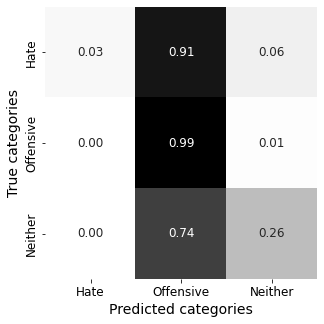

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

#### Hierarchical version 2 performance (first hate vs (offensive/neither), then offensive vs neither

In [ ]:
lgs_reg21, lgs_reg22 = train2(X_train, y_train)

In [ ]:
y_preds2 = predict2(X_test, lgs_reg21, lgs_reg22)

In [ ]:
report = classification_report( y_test, y_preds2 )
print(report)

              precision    recall  f1-score   support

           0       0.09      0.85      0.16       164
           1       0.97      0.09      0.16      1905
           2       0.24      0.40      0.30       410

    accuracy                           0.19      2479
   macro avg       0.43      0.45      0.21      2479
weighted avg       0.79      0.19      0.19      2479



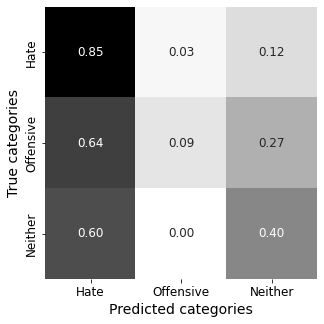

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

confusion_matrix = confusion_matrix(y_test,y_preds2)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)